In [1]:
import gym


import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN):
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_win = n_win

        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.gameOver = False
        self.boardHash = None
        # ход первого игрока
        self.curTurn = 1
        self.emptySpaces = None
        
        self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def _check_terminal(self, cur_p):
        cur_marks = np.where(self.board == cur_p)
        for i,j in zip(cur_marks[0], cur_marks[1]):
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    return True
            if j <= self.n_cols - self.n_win:
                if np.all(self.board[i,j:j+self.n_win] == cur_p):
                    return True
            if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                    return True
            if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                    return True
        return False
    
    def isTerminal(self):
        # проверим, не закончилась ли игра
        cur_win = self._check_terminal(self.curTurn)
        if cur_win:
                self.gameOver = True
                return self.curTurn
            
        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def getWinner(self):
        # фактически запускаем isTerminal два раза для крестиков и ноликов
        if self._check_terminal(1):
            return 1
        if self._check_terminal(-1):
            return -1
        if len(self.getEmptySpaces()) == 0:
            return 0
        return None
    
    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

### Часть первая: крестики-нолики при помощи Q-обучения
### В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.


In [4]:
env = TicTacToe()

In [5]:
def epsilon_greedy(env, Q, epsilon=0.01):
    possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
    
    if env.getState()[0] not in Q.keys():
        Q[env.getState()[0]] = np.zeros(len(possible_actions))
        
    if np.random.random() > epsilon:
        return np.argmax(Q[env.getState()[0]]), possible_actions[np.argmax(Q[env.getState()[0]])]
    else:
        choice = np.random.choice(len(possible_actions))
        return choice, possible_actions[choice]

In [6]:
def Q_learning_episode(strategy, env, Q, lr=0.01, gamma=1.0, crosses=1):
    env.reset()
    if env.curTurn != crosses:
        possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        opponents_action = np.random.choice(possible_actions)
        env.step(env.action_from_int(opponents_action))
        
    while True:
        state = env.getState()[0]

        q_action, action = strategy(env, Q)

        _, reward, done, _ = env.step(env.action_from_int(action))
        reward = crosses * reward
        if done:
            Q[state][q_action] += lr * (reward  - Q[state][q_action])
            return reward

        possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
        opponents_action = np.random.choice(possible_actions)
            
        next_state_, reward, done, _ = env.step(env.action_from_int(opponents_action))
        reward = crosses * reward
        if done:
            Q[state][q_action] += lr * (reward  - Q[state][q_action])
            return reward
            
        next_state = next_state_[0]
        if next_state in Q.keys():
            Q[state][q_action] += lr * (reward + gamma * np.max(Q[next_state]) - Q[state][q_action])
        else:
            possible_actions = [env.int_from_action(env.getEmptySpaces()[i]) for i in range(len(env.getEmptySpaces()))]
            Q[next_state] = np.zeros(len(possible_actions))
            Q[state][q_action] += lr * (reward + gamma * np.max(Q[next_state]) - Q[state][q_action])

In [7]:
def learn(strategy, env=TicTacToe(), n_games=int(1e5), print_step=1000, save_step=1000, crosses=1):
    mean_game_rewards = []
    avg_every = []
    Q = {}
    for i in tqdm(range(n_games)):
        R = Q_learning_episode(strategy, env, Q, crosses=crosses)
        avg_every.append(R)
        if (i + 1) % print_step == 0:
            print("{} games avg rewards: {}".format(i + 1, np.mean(avg_every)))
        if (i + 1) % save_step == 0:
            mean_game_rewards.append(np.mean(avg_every))
            avg_every = []
    return Q, mean_game_rewards

In [8]:
Q_crosses, rewards_q_learning_crosses = learn(epsilon_greedy, print_step=int(1e4), save_step=1000, crosses=1)
Q_nills, rewards_q_learning_nills = learn(epsilon_greedy, print_step=int(1e4), save_step=1000, crosses=-1)

  0%|          | 0/100000 [00:00<?, ?it/s]

10000 games avg rewards: 0.852
20000 games avg rewards: 0.89
30000 games avg rewards: 0.859
40000 games avg rewards: 0.875
50000 games avg rewards: 0.861
60000 games avg rewards: 0.87
70000 games avg rewards: 0.89
80000 games avg rewards: 0.873
90000 games avg rewards: 0.866
100000 games avg rewards: 0.861


  0%|          | 0/100000 [00:00<?, ?it/s]

10000 games avg rewards: 0.668
20000 games avg rewards: 0.649
30000 games avg rewards: 0.695
40000 games avg rewards: 0.714
50000 games avg rewards: 0.71
60000 games avg rewards: 0.709
70000 games avg rewards: 0.719
80000 games avg rewards: 0.731
90000 games avg rewards: 0.717
100000 games avg rewards: 0.727


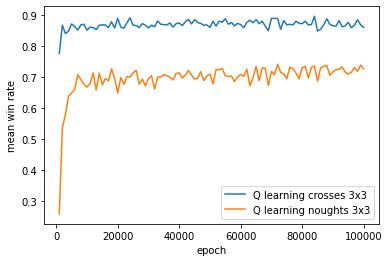

In [9]:
plt.plot(np.array(list(range(1,101)))*1000, rewards_q_learning_crosses, label='Q learning crosses 3x3')
plt.plot(np.array(list(range(1,101)))*1000, rewards_q_learning_nills, label='Q learning noughts 3x3')
plt.xlabel('epoch')
plt.ylabel('mean win rate')
plt.legend();

### 4x4

In [10]:
env = TicTacToe(4, 4, 4)

In [11]:
Q_crosses, rewards_q_learning_crosses = learn(epsilon_greedy, env=env, print_step=int(1e4), save_step=1000, crosses=1)
Q_nills, rewards_q_learning_nills = learn(epsilon_greedy, env=env, print_step=int(1e4), save_step=1000, crosses=-1)

  0%|          | 0/100000 [00:00<?, ?it/s]

10000 games avg rewards: 0.583
20000 games avg rewards: 0.644
30000 games avg rewards: 0.647
40000 games avg rewards: 0.658
50000 games avg rewards: 0.683
60000 games avg rewards: 0.696
70000 games avg rewards: 0.718
80000 games avg rewards: 0.735
90000 games avg rewards: 0.721
100000 games avg rewards: 0.719


  0%|          | 0/100000 [00:00<?, ?it/s]

10000 games avg rewards: 0.337
20000 games avg rewards: 0.332
30000 games avg rewards: 0.365
40000 games avg rewards: 0.389
50000 games avg rewards: 0.443
60000 games avg rewards: 0.376
70000 games avg rewards: 0.436
80000 games avg rewards: 0.454
90000 games avg rewards: 0.447
100000 games avg rewards: 0.46


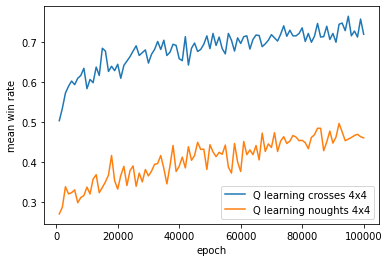

In [12]:
plt.plot(np.array(list(range(1,101)))*1000, rewards_q_learning_crosses, label='Q learning crosses 4x4')
plt.plot(np.array(list(range(1,101)))*1000, rewards_q_learning_nills, label='Q learning noughts 4x4')
plt.xlabel('epoch')
plt.ylabel('mean win rate')
plt.legend();

### 5x5

In [13]:
env = TicTacToe(5, 5, 5)

In [14]:
Q_crosses, rewards_q_learning_crosses = learn(epsilon_greedy, env=env, print_step=int(1e4), save_step=1000, crosses=1)
Q_nills, rewards_q_learning_nills = learn(epsilon_greedy, env=env, print_step=int(1e4), save_step=1000, crosses=-1)

  0%|          | 0/100000 [00:00<?, ?it/s]

10000 games avg rewards: 0.587
20000 games avg rewards: 0.605
30000 games avg rewards: 0.583
40000 games avg rewards: 0.597
50000 games avg rewards: 0.603
60000 games avg rewards: 0.594
70000 games avg rewards: 0.593
80000 games avg rewards: 0.606
90000 games avg rewards: 0.603
100000 games avg rewards: 0.579


  0%|          | 0/100000 [00:00<?, ?it/s]

10000 games avg rewards: 0.248
20000 games avg rewards: 0.27
30000 games avg rewards: 0.238
40000 games avg rewards: 0.283
50000 games avg rewards: 0.274
60000 games avg rewards: 0.331
70000 games avg rewards: 0.286
80000 games avg rewards: 0.224
90000 games avg rewards: 0.242
100000 games avg rewards: 0.212


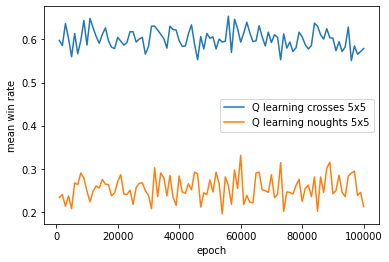

In [15]:
plt.plot(np.array(list(range(1,101)))*1000, rewards_q_learning_crosses, label='Q learning crosses 5x5')
plt.plot(np.array(list(range(1,101)))*1000, rewards_q_learning_nills, label='Q learning noughts 5x5')
plt.xlabel('epoch')
plt.ylabel('mean win rate')
plt.legend();